In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import missingno as msno
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

from rich import pretty, print # optional dependency for more readable output
pretty.install()

import warnings
warnings.filterwarnings("ignore")


In [2]:
df_train = pd.read_csv("train_v9rqX0R.csv")
print(df_train.columns)
df_train

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


### Problem
We are given the above dataset of 1559 products sold across 10 stores regarding their sales and our task is to build a model that will capture the most influential features of the product and stores in order to maximize sales, a **regression problem** there is no factor of time hence no time series analysis is required.

### Initial Evaluation
Before performing EDA and impact of features, we can make some initial assessments, we will see how much the data agrees with our intuition, it appears:
1. The attributes related to products must highlight the general public demand and trend related to the product itself.
2. The attributes related to the store, including its location and type (whether a supermarket or not) must capture the influence of the store on the sales of the product.

For example according to a comparative analysis performed on **Retail Distribution** in Supermarkets vs Speciality stores [[1]](https://www.sciencedirect.com/science/article/abs/pii/S0969698912000768) here are some conclusions we can infer:
1. Consumers are more likely to purchase premium gifting products (such as boxed chocolates) from speciality stores rather than supermarkets.
2. Overall sales of a product are greater in supermarkets due to promotions and offers. However, the paper does not cover the type of the city which is a variable we are supplied with 'Outles_Location_Type' -> Tier 1, Tier 2, Tier 3. Based on intuition, we expect supermarkets to perform better in Tier 1 cities, where factors like convenience, parking, and local bank promotions are more prevalent.
3. There is also the holiday factor "the holiday impact is more prominent in the specialty store" which we will avoid assuming the has been collected evenly in 2013.

Further,
1. The Item_Weight along with its ratio with Item_MRP can also influence a person into buying, we can engineer this feature.
2. Due to increasing health consciousness, Low_Fat items must sell more in Tier 1 and 2 cities esp. for Meat and Dairy products.
3. Item_Visibility must also influence its sales.
4. Outlet_Establishment_Year, older shops must have more consumer trust and sales.
5. The Item_MRP itself is a little vague feature, it must be taken in accordance to Item_Type (such as meat) or Item_Weight and Outlet_Location_Type.

From the sight of it, the factors that decide sales appear interwoven in a decision tree like manner, thus a Tree-Based Regressor must be preferred as our choice for the Final Model, we will use Linear Regression as a Baseline Model for benchmarking.


### Initial Correlations
Before working on the dataset, we would like to see how the variables relate to the response variable so we can better see how our changes will reflect upon the correlations

Below, we will make a dummy dataset ready to for checking correlations

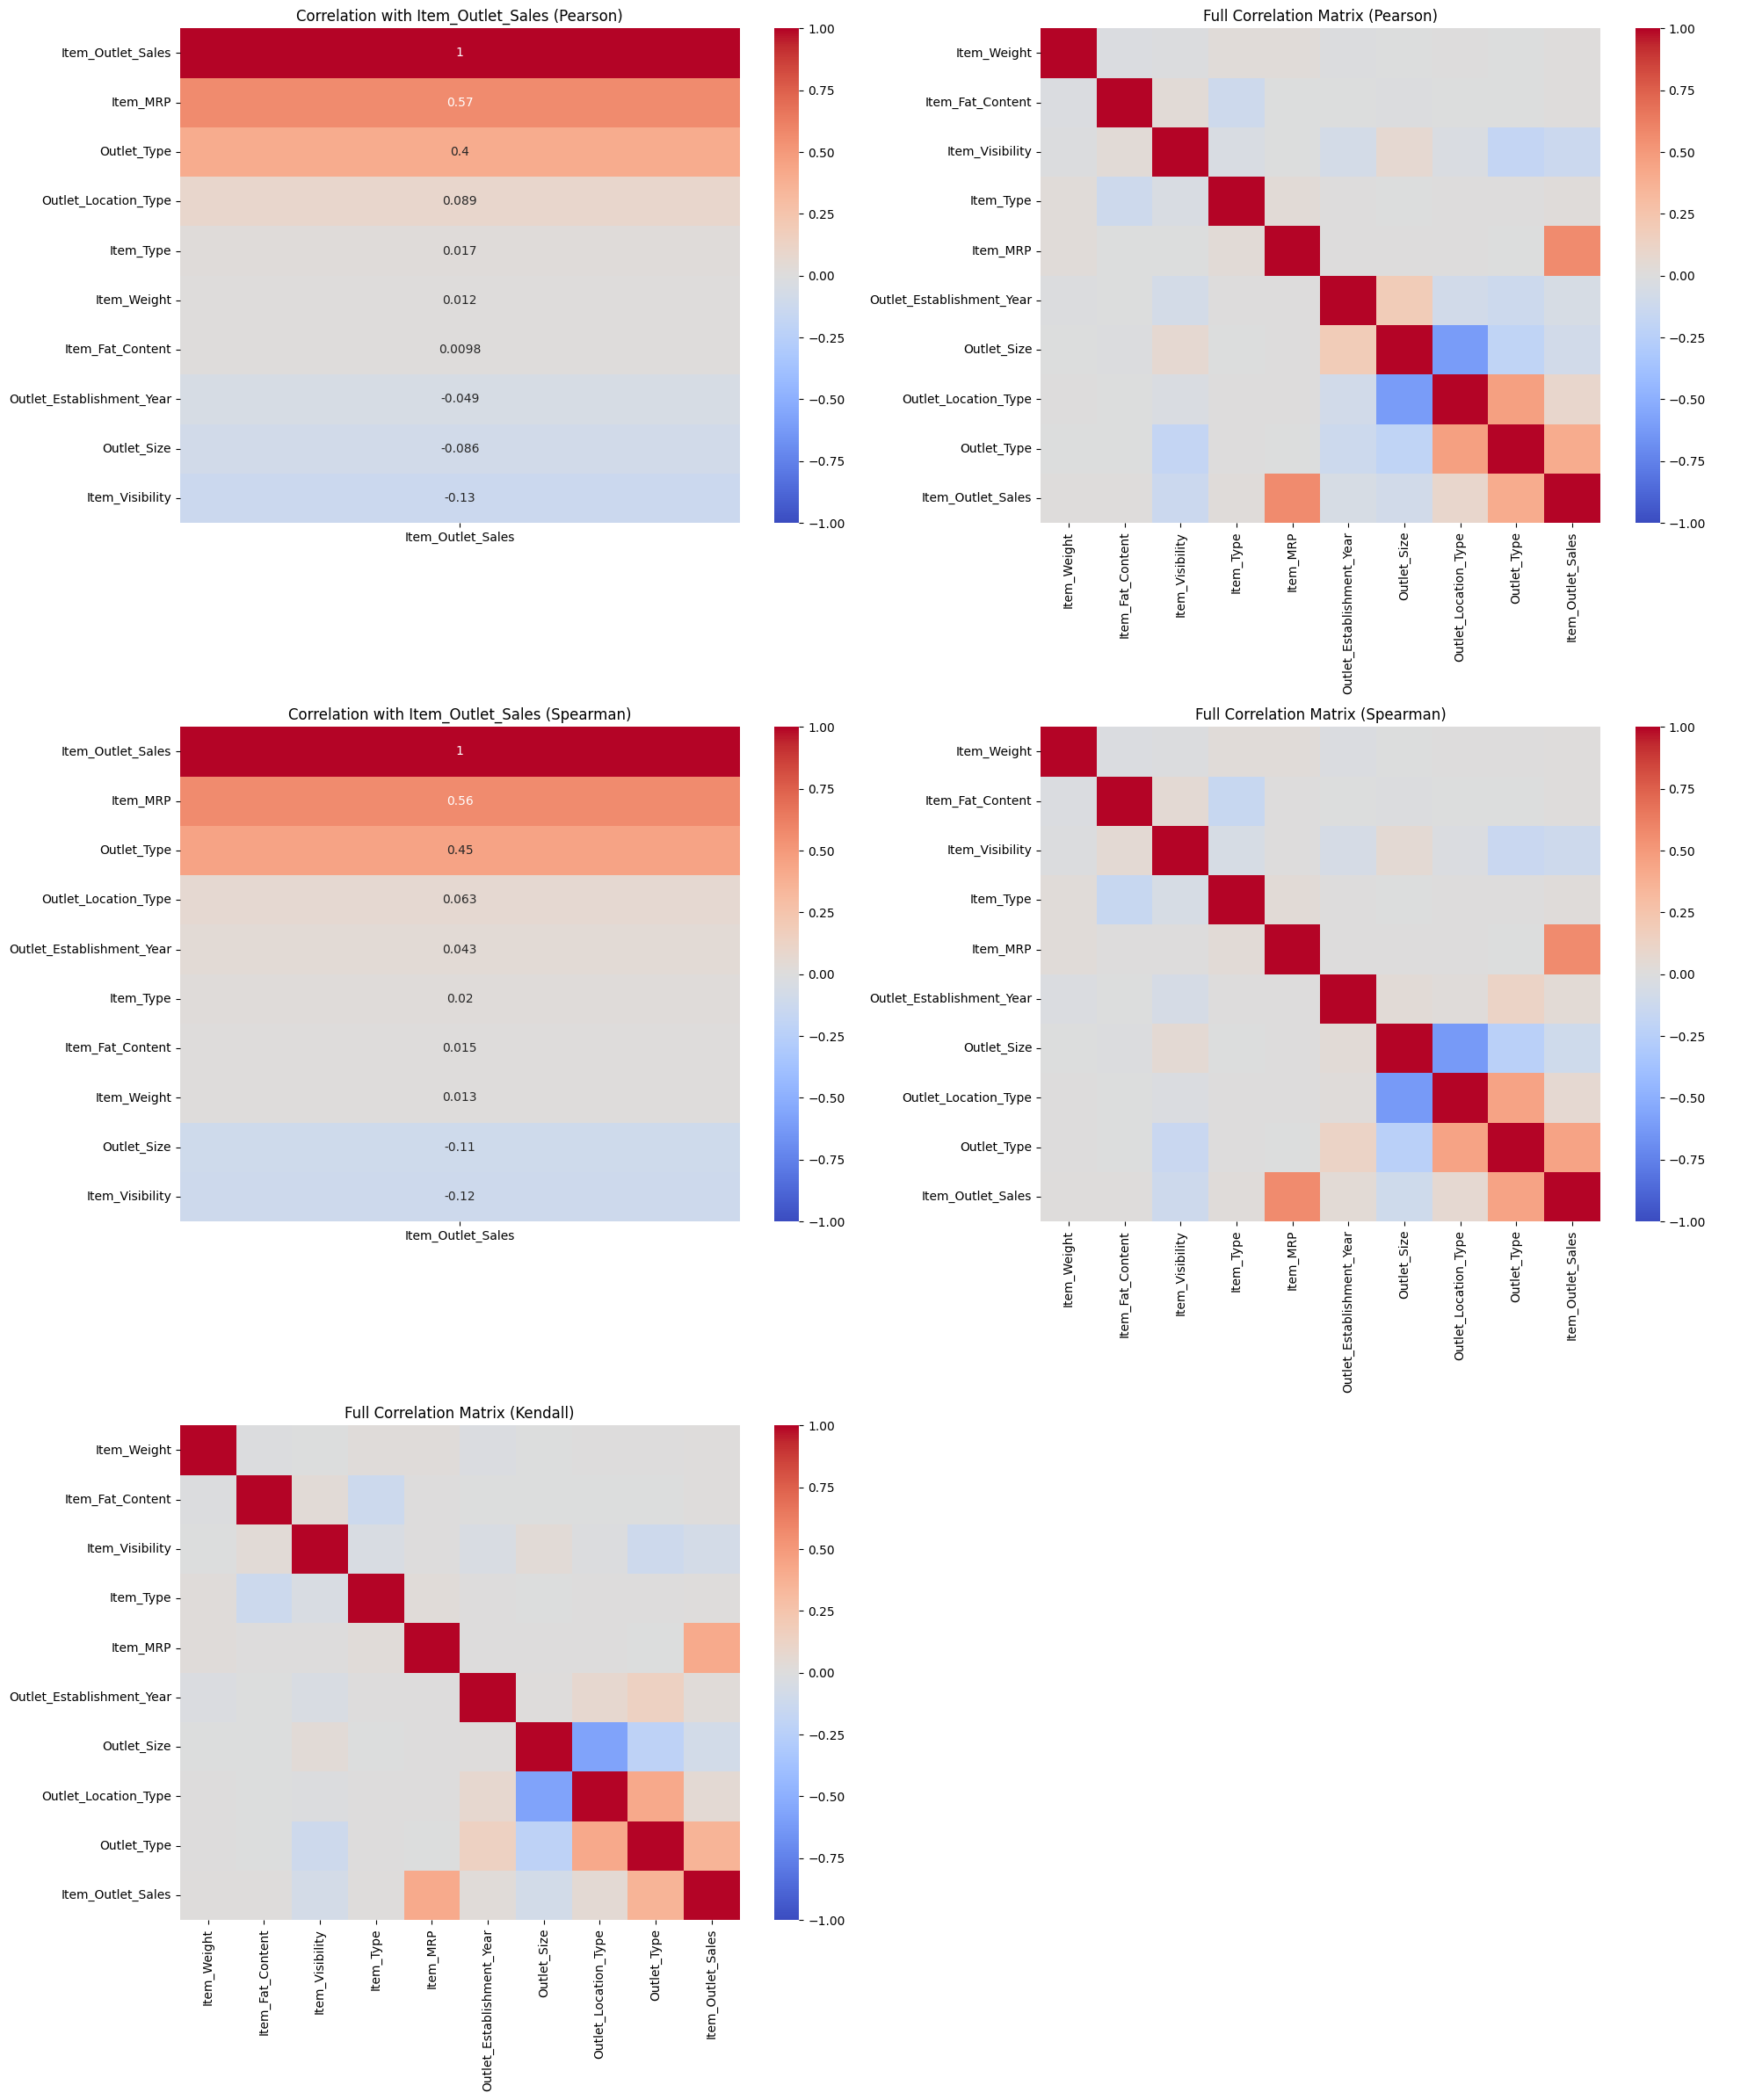

In [3]:
dummy = pd.read_csv("train_v9rqX0R.csv")

categorical_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
dummy['Item_Weight'].fillna(dummy['Item_Weight'].mean(), inplace=True)
dummy['Outlet_Size'].fillna(dummy['Outlet_Size'].mode()[0], inplace=True)

label_encoder = LabelEncoder()
for col in categorical_columns:
    dummy[col] = label_encoder.fit_transform(dummy[col])

def df_heatmap(df, by: str = 'Item_Outlet_Sales', only_pearson: bool = False):
    numeric_data = df.drop(columns=['Item_Identifier', 'Outlet_Identifier'])

    corr_pearson = numeric_data.corr(method='pearson')

    if only_pearson:
        response_corr_pearson = corr_pearson[[by]].sort_values(by=by, ascending=False)

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        sns.heatmap(response_corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
        axes[0].set_title('Correlation with Item_Outlet_Sales (Pearson)')

        sns.heatmap(corr_pearson, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
        axes[1].set_title('Full Correlation Matrix (Pearson)')
    else:
        corr_spearman = numeric_data.corr(method='spearman')
        corr_kendall = numeric_data.corr(method='kendall')

        response_corr_pearson = corr_pearson[[by]].sort_values(by=by, ascending=False)
        response_corr_spearman = corr_spearman[[by]].sort_values(by=by, ascending=False)

        fig, axes = plt.subplots(3, 2, figsize=(20, 24))

        sns.heatmap(response_corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0, 0])
        axes[0, 0].set_title('Correlation with Item_Outlet_Sales (Pearson)')

        sns.heatmap(corr_pearson, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0, 1])
        axes[0, 1].set_title('Full Correlation Matrix (Pearson)')

        sns.heatmap(response_corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1, 0])
        axes[1, 0].set_title('Correlation with Item_Outlet_Sales (Spearman)')

        sns.heatmap(corr_spearman, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1, 1])
        axes[1, 1].set_title('Full Correlation Matrix (Spearman)')

        sns.heatmap(corr_kendall, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[2, 0])
        axes[2, 0].set_title('Full Correlation Matrix (Kendall)')

        axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()


df_heatmap(dummy, 'Item_Outlet_Sales')

Initially it seems like the sales mainly depends upon MRP of the item and the outlet type, whether a supermarket or grocery, and somewhat on the location. In this dataset, for now, our other hypothesis do not have solid grounds.

# Data Cleaning
Finally we will work on our actual dataset

### Missing Values

<Axes: >

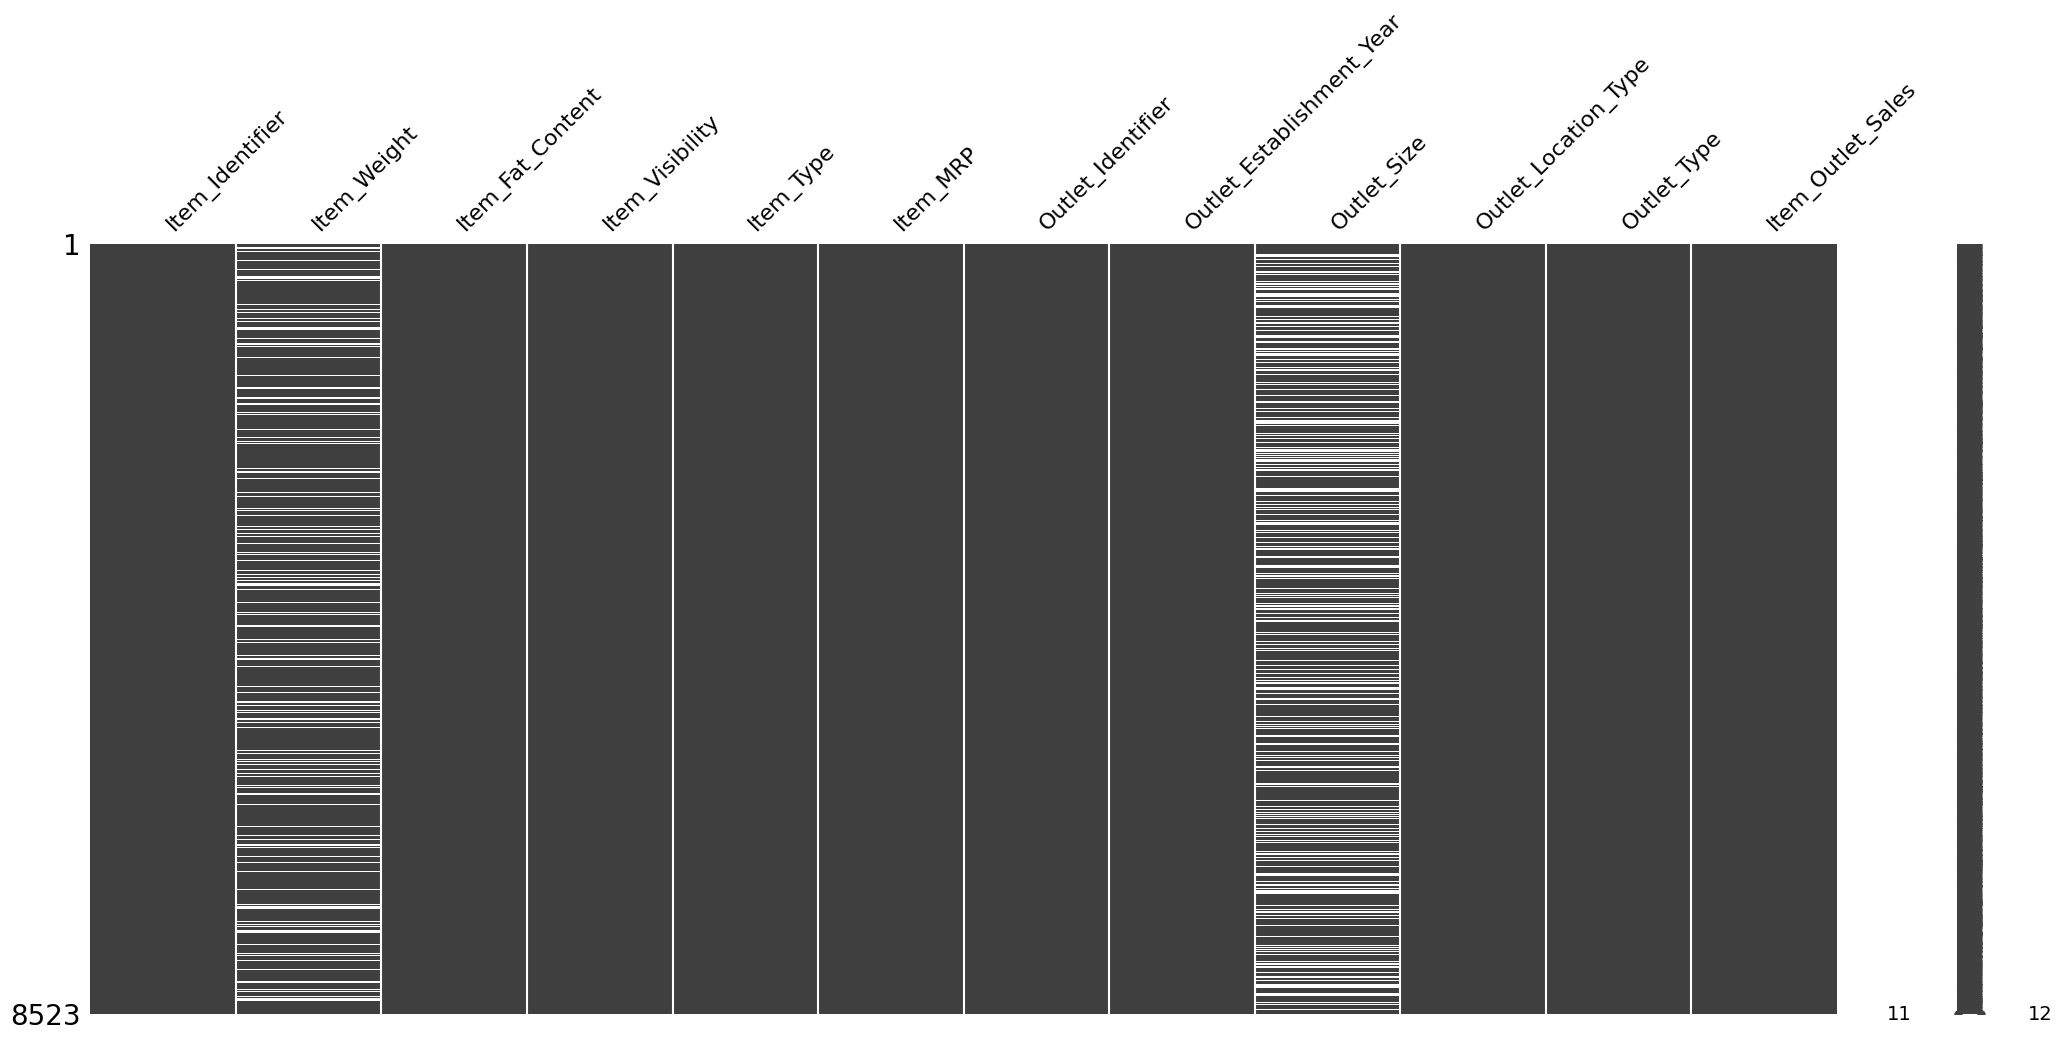

In [4]:
msno.matrix(df_train)

In [5]:
df_train['Outlet_Size'].isnull().sum() / 8523 * 100, df_train['Item_Weight'].isnull().sum() / 8523 * 100

(np.float64(28.27642848762173), np.float64(17.165317376510618))

28% missing values in **Outlet_Size** and 17% in **Item_Weight**

Item_Weight: there is no way to create a predictive model using other available features that can be used to impute Item_Weight. Imputing the mean for 17% missing values will render the column inoperable for regressors by ruining the distribution as inferred from the two below plots. Hence we will drop Item_Weight.

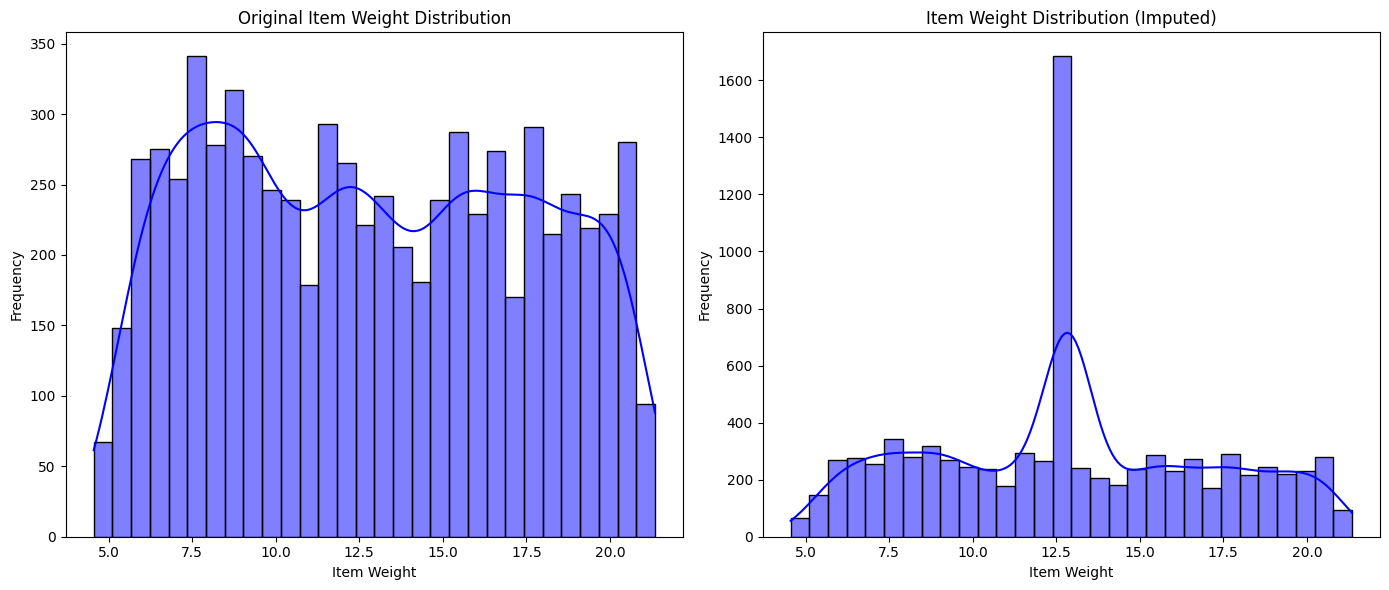

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_train['Item_Weight'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title('Original Item Weight Distribution')
axes[0].set_xlabel('Item Weight')
axes[0].set_ylabel('Frequency')

Item_Weight_Col = df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean())
sns.histplot(Item_Weight_Col, kde=True, color='blue', bins=30, ax=axes[1])
axes[1].set_title('Item Weight Distribution (Imputed)')
axes[1].set_xlabel('Item Weight')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

In [7]:
df_train.drop(columns=['Item_Weight'], inplace=True)

The Outlet_Size will be dropped since 28% values are missing. Outlet_Size is a minor redundancy since Outlet_Type and Outlet_Location_Type among other Outlet features and the sales it already gives our model a rough idea about Outlet_Size.

Note that the Outlet_Size may be reproduced with 100% accuracy since there are only 10 stores overall it is possible that size of a store was not recorded in all of its appearances, and thus can be filled wherever it is absent by taking the mode of where it is present. Nonetheless, this column does not have a strong correlation and is a redundancy so we will drop it.

In [8]:
df_train.drop(columns=['Outlet_Size'], inplace=True)

### Encoding and Serialization of Categorical Variables

The dataset requires imputation, encoding and serialization appropriately before it can be used. First we will deal with categorical variables

In [9]:
print(df_train['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

We will unify the different nomenclature into lf -> 0 and reg -> 1

In [10]:
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace(
    {'Low Fat': 'lf', 'LF': 'lf', 'low fat': 'lf', 'Regular': 'reg', 'reg': 'reg'}
)
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].map({'lf': 0, 'reg': 1})


In [11]:
df_train['Item_Fat_Content'].value_counts()


Item_Fat_Content
0    5517
1    3006
Name: count, dtype: int64

It seems like the data categorizes everything into Low_Fat or Regular_Fat including softdrinks, detergents etc, while the value is only relevant with meat and dairy products etc, it is thus probably best to create three categories:

- N/A -> 0
- Low_Fat -> 1
- Regular -> 2

This will avoid saturating the Low_Fat value and give it its due importance
We will do this in a moment

Onto the next column

In [12]:
df_train["Item_Type"].value_counts()


Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [13]:
df_train['Item_Type'].describe()


count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object

We have total 16 categories, except for 'health and hygiene', 'household' and 'others' all the cats are food products we will create some features out of them in FE section, for now let's improve the Item_Fat column, the column is only relevant in the following cats:
- Fruits and Vegetables
- Snack Foods
- Frozen Foods
- Dairy
- Canned
- Baking Goods
- Meat
- Starchy Foods (sometimes the product is fried or processed)
- Breakfast
- Seafood

We can always see the distribution of Low_Fat and High_Fat for each of the Food_Type if one category of fat is extremely dominant then we can manually inspect if the fat categorization is even relevant or not.

In [14]:
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace({0: 1, 1: 2})
valid_item_types = [
    'Fruits and Vegetables', 'Snack Foods', 'Frozen Foods', 'Dairy', 
    'Canned', 'Baking Goods', 'Meat', 'Starchy Foods', 'Breakfast', 'Seafood'
]
df_train.loc[~df_train['Item_Type'].isin(valid_item_types), 'Item_Fat_Content'] = 0
df_train.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,1,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,DRC01,0,0.019278,Soft Drinks,48.2692,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,FDN15,1,0.016760,Meat,141.6180,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,FDX07,2,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,NCD19,0,0.000000,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052


Moving to next column, Estb. Year

In [15]:
df_train['Outlet_Establishment_Year'].value_counts().sort_index()


Outlet_Establishment_Year
1985    1463
1987     932
1997     930
1998     555
1999     930
2002     929
2004     930
2007     926
2009     928
Name: count, dtype: int64

We will categorize the outlet estb. year according to decade, 80s, 90s, mid 00s, late 00s in one-hot fashion, this almost evenly categorizes them
We would not want to use linear serialization to not confuse the linear regression model as it is not necessarily a linear feature

In [16]:
def categorize_decade(year):
    if 1980 <= year < 1990:
        return '80s'
    elif 1990 <= year < 2000:
        return '90s'
    elif 2000 <= year < 2005:
        return 'mid 00s'
    else:
        return 'late 00s'

df_train['Decade'] = df_train['Outlet_Establishment_Year'].apply(categorize_decade)
df_train = pd.get_dummies(df_train, columns=['Decade'], drop_first=False)

In [17]:
df_train = df_train.drop('Outlet_Establishment_Year', axis=1)

In [18]:
df_train.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Decade_80s,Decade_90s,Decade_late 00s,Decade_mid 00s
0,FDA15,1,0.016047,Dairy,249.8092,OUT049,Tier 1,Supermarket Type1,3735.1380,False,True,False,False
1,DRC01,0,0.019278,Soft Drinks,48.2692,OUT018,Tier 3,Supermarket Type2,443.4228,False,False,True,False
2,FDN15,1,0.016760,Meat,141.6180,OUT049,Tier 1,Supermarket Type1,2097.2700,False,True,False,False
3,FDX07,2,0.000000,Fruits and Vegetables,182.0950,OUT010,Tier 3,Grocery Store,732.3800,False,True,False,False
4,NCD19,0,0.000000,Household,53.8614,OUT013,Tier 3,Supermarket Type1,994.7052,True,False,False,False


In [19]:
# Also for the Item_Type column there is not much grouping to perform but it will compromise information, thus we will one-hot encode the 16 features
df_train = pd.get_dummies(df_train, columns=['Item_Type'], drop_first=False)
df_train.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Decade_80s,Decade_90s,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,1,0.016047,249.8092,OUT049,Tier 1,Supermarket Type1,3735.1380,False,True,...,False,False,False,False,False,False,False,False,False,False
1,DRC01,0,0.019278,48.2692,OUT018,Tier 3,Supermarket Type2,443.4228,False,False,...,False,False,False,False,False,False,False,False,True,False
2,FDN15,1,0.016760,141.6180,OUT049,Tier 1,Supermarket Type1,2097.2700,False,True,...,False,False,False,False,True,False,False,False,False,False
3,FDX07,2,0.000000,182.0950,OUT010,Tier 3,Grocery Store,732.3800,False,True,...,True,False,False,False,False,False,False,False,False,False
4,NCD19,0,0.000000,53.8614,OUT013,Tier 3,Supermarket Type1,994.7052,True,False,...,False,False,False,True,False,False,False,False,False,False


Now we will perform simple linear serialization on Outlet Location type
- Tier1 -> 1
- Tier2 -> 2
- Tier3 -> 3

In [20]:
df_train['Outlet_Location_Type'].value_counts()


Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64

In [21]:
df_train['Outlet_Location_Type'] = df_train['Outlet_Location_Type'].map({'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3})
df_train.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Decade_80s,Decade_90s,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,1,0.016047,249.8092,OUT049,1,Supermarket Type1,3735.1380,False,True,...,False,False,False,False,False,False,False,False,False,False
1,DRC01,0,0.019278,48.2692,OUT018,3,Supermarket Type2,443.4228,False,False,...,False,False,False,False,False,False,False,False,True,False
2,FDN15,1,0.016760,141.6180,OUT049,1,Supermarket Type1,2097.2700,False,True,...,False,False,False,False,True,False,False,False,False,False
3,FDX07,2,0.000000,182.0950,OUT010,3,Grocery Store,732.3800,False,True,...,True,False,False,False,False,False,False,False,False,False
4,NCD19,0,0.000000,53.8614,OUT013,3,Supermarket Type1,994.7052,True,False,...,False,False,False,True,False,False,False,False,False,False


Now we just have to encode Outlet_Type

In [22]:
df_train['Outlet_Type'].value_counts()


Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64

We have 3 categories of Supermarkets and we would like to preserve this information, hence we will one-hot encode this column, if the types were to be only Grocery and Supermarket we could have serialized them

In [23]:
df_train = pd.get_dummies(df_train, columns=['Outlet_Type'], prefix='Outlet_Type', drop_first=False)
df_train

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Location_Type,Item_Outlet_Sales,Decade_80s,Decade_90s,Decade_late 00s,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,1,0.016047,249.8092,OUT049,1,3735.1380,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,DRC01,0,0.019278,48.2692,OUT018,3,443.4228,False,False,True,...,False,False,False,False,True,False,False,False,True,False
2,FDN15,1,0.016760,141.6180,OUT049,1,2097.2700,False,True,False,...,True,False,False,False,False,False,False,True,False,False
3,FDX07,2,0.000000,182.0950,OUT010,3,732.3800,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,NCD19,0,0.000000,53.8614,OUT013,3,994.7052,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,1,0.056783,214.5218,OUT013,3,2778.3834,True,False,False,...,False,False,False,True,False,False,False,True,False,False
8519,FDS36,2,0.046982,108.1570,OUT045,2,549.2850,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8520,NCJ29,0,0.035186,85.1224,OUT035,2,1193.1136,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8521,FDN46,2,0.145221,103.1332,OUT018,3,1845.5976,False,False,True,...,False,False,False,True,False,False,False,False,True,False


The 'Item_Visibility' has heavy positive skew as shown below, thus we will normalize it for our linear models

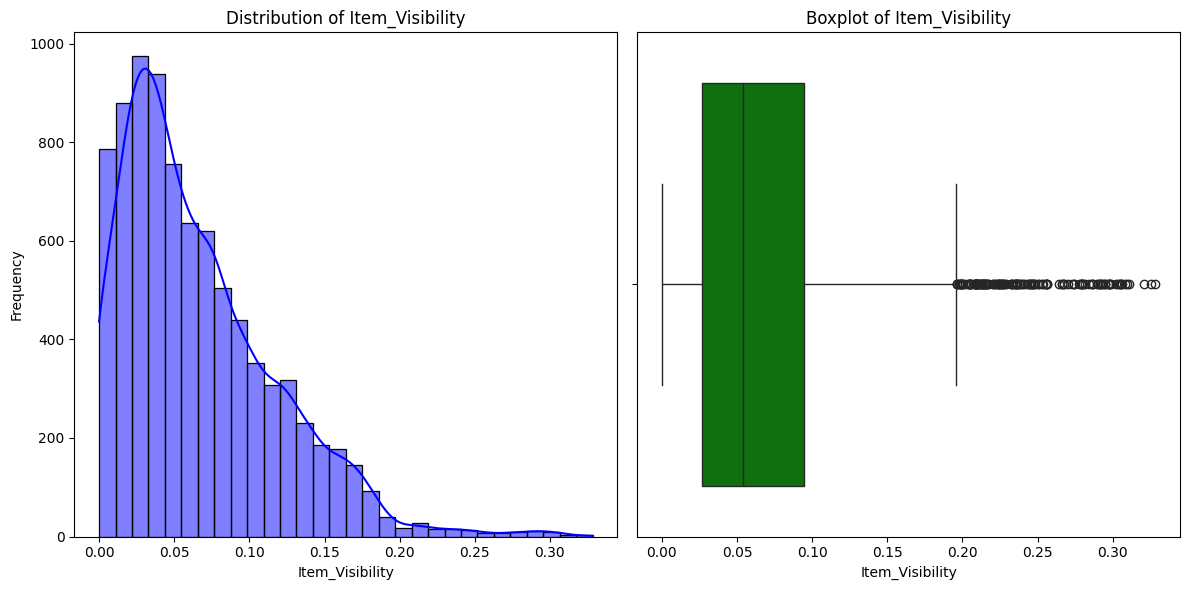

In [24]:
# Plotting the distribution of Item_Visibility
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Visibility'], kde=True, color='blue', bins=30)
plt.title('Distribution of Item_Visibility')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequency')

# Boxplot to visualize outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_train['Item_Visibility'], color='green')
plt.title('Boxplot of Item_Visibility')
plt.xlabel('Item_Visibility')

plt.tight_layout()

In [25]:
df_train['Item_Visibility'], _ = stats.boxcox(df_train['Item_Visibility'] + 1)

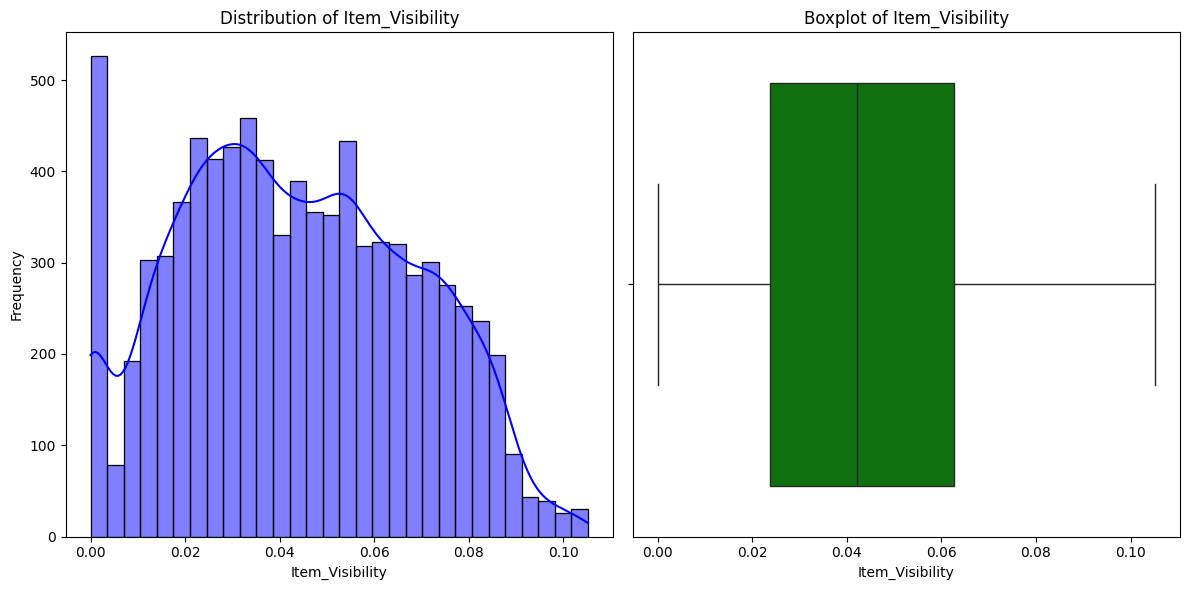

In [26]:
# Plotting the distribution of Item_Visibility
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Visibility'], kde=True, color='blue', bins=30)
plt.title('Distribution of Item_Visibility')
plt.xlabel('Item_Visibility')
plt.ylabel('Frequency')

# Boxplot to visualize outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_train['Item_Visibility'], color='green')
plt.title('Boxplot of Item_Visibility')
plt.xlabel('Item_Visibility')

plt.tight_layout()

There are some items with very zero visibility, which is possible for items that are behind other items in the shelves, so we will leave it as it is assuming this is not a glitch in system

In [27]:
(df_train['Item_Visibility'] == 0).sum()

np.int64(526)

# Exploratory Data Analysis
The data has been cleaned, now we can being to analyse it

### Response Variable: Item_Outlet_Sales

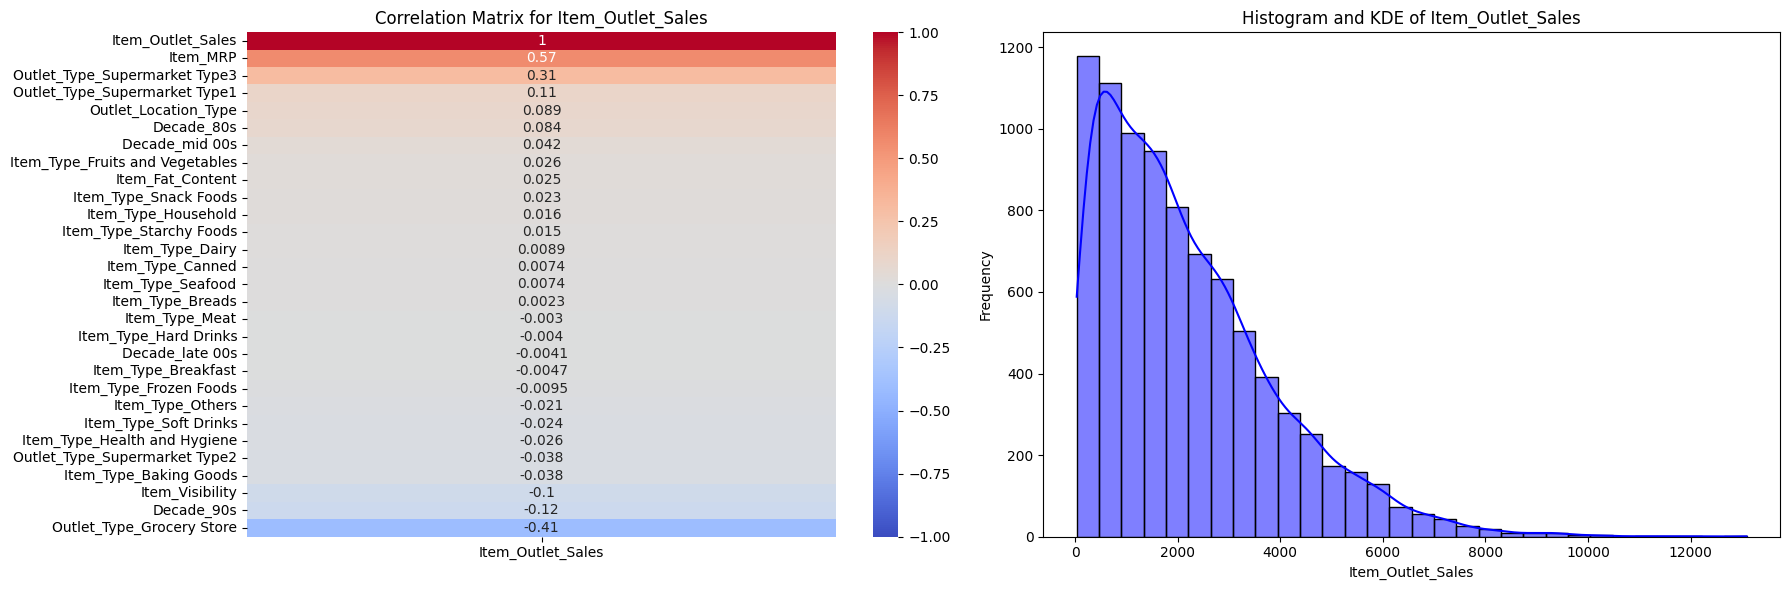

In [28]:
# Corr matrix and Histogram plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
corr_matrix = df_train.drop(columns=['Item_Identifier', 'Outlet_Identifier']).corr()
response_corr = corr_matrix[['Item_Outlet_Sales']].sort_values(by='Item_Outlet_Sales', ascending=False)

sns.heatmap(response_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Correlation Matrix for Item_Outlet_Sales')

# Histogram for Item_Outlet_Sales
sns.histplot(df_train['Item_Outlet_Sales'], kde=True, color='blue', bins=30, ax=axes[1])
axes[1].set_title('Histogram and KDE of Item_Outlet_Sales')
axes[1].set_xlabel('Item_Outlet_Sales')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Insights
1. After modification of the dataset we see that Outlet_Type = Grocery has negative correlation with the Sales price. This was not visible earlier. This is well-expected since supermarts can maximize sales from their offers, promotions and more visibility. It is also important to realize that supermarkets purchase more and sell more to a greater amount of consumers hence this trend might not be true for every item type as witnessed in [1] we will have to check if there is an Item_Type that is sold better in grocery stores rather than supermarkets, this can be achieved by segregating the dataset into a supermarket dataset and a grocery store dataset.
2. Our target variable is 'Item_Outlet_Sales' which will always scale positively with 'Item_MRP', since $Sales = MRP \times Items$. We need to introduce a new feature 'Sales_Volume' where $V = \frac{Sales}{MRP}$ to get a raw measurement of items sold and see if they have a relation with MRP
3. The Sales graph is skewed heavily to right, this is expected as more expensive purchases are less frequently made
4. Another thing we notice is that Outlets made in 90s do not have a good record compared to Outlets made in 80s, this insight was missing in the initial correlation matrix, it became manifest after binning of the Establishment Year

Below we will segregate the dataset to see which item types sell better in grocery stores against supermarkets. We will sample equal amount of rows from supermarts to make the comparision fair

In [29]:
# Subset for Outlet_Type Supermarket (Type1, Type2, or Type3)
df_supermarket = df_train[
    (df_train['Outlet_Type_Supermarket Type1'] == 1) | 
    (df_train['Outlet_Type_Supermarket Type2'] == 1) | 
    (df_train['Outlet_Type_Supermarket Type3'] == 1)
]

# Subset for Outlet_Type Grocery Store
df_grocery = df_train[df_train['Outlet_Type_Grocery Store'] == 1]


In [30]:
df_supermarket_sampled = df_supermarket.sample(n=len(df_grocery), random_state=8317)

item_types = ['Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
              'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
              'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
              'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
              'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
              'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods']

# Aggregate sales for each item type
grocery_sales = df_grocery[item_types].multiply(df_grocery['Item_Outlet_Sales'], axis=0).sum()
supermarket_sales = df_supermarket_sampled[item_types].multiply(df_supermarket_sampled['Item_Outlet_Sales'], axis=0).sum()

better_in_grocery = grocery_sales[grocery_sales > supermarket_sales]

print("Item types sold better in grocery stores than supermarkets (after sampling):")
print(better_in_grocery)


Item types sold better in grocery stores than supermarkets (after sampling):

Series([], dtype: float64)

It seems like supermarkets are just better

Below are the sales plots

<Figure size 1400x700 with 0 Axes>

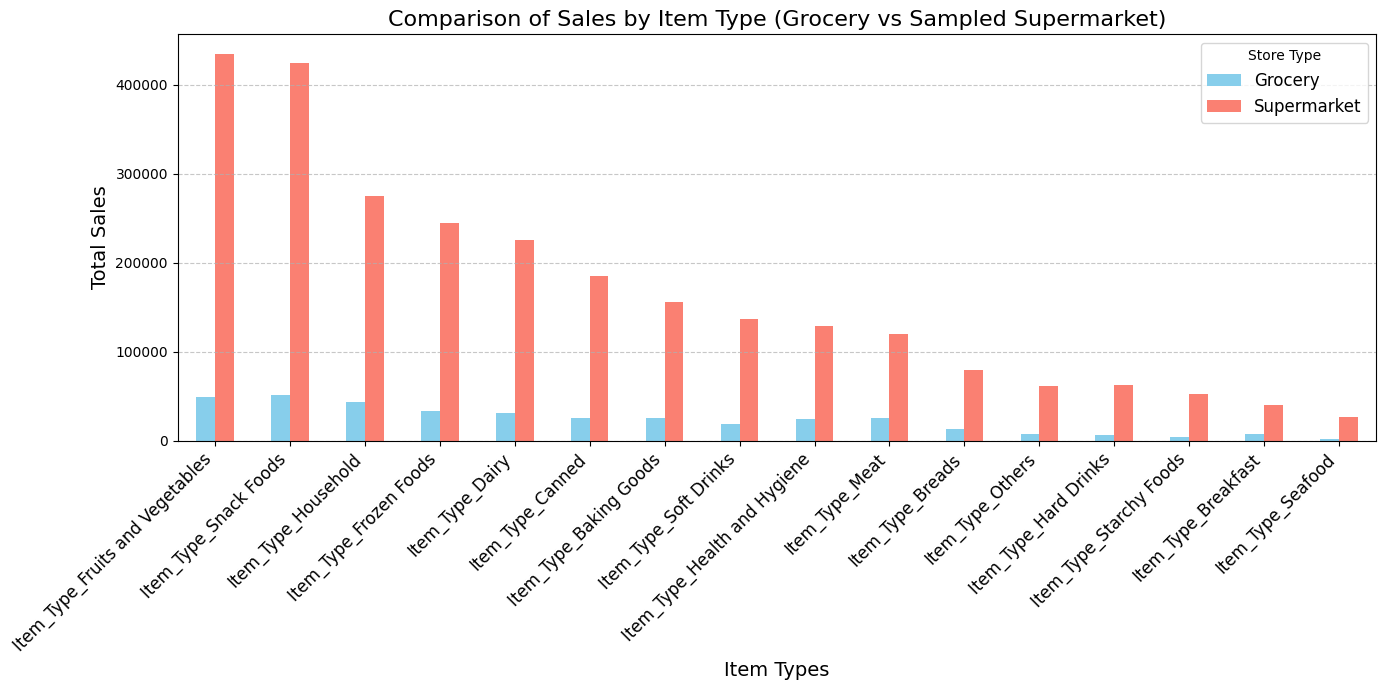

In [31]:
plt.figure(figsize=(14, 7))

sales_comparison = pd.DataFrame({
    'Grocery': grocery_sales,
    'Supermarket': supermarket_sales
})

sales_comparison = sales_comparison.loc[sales_comparison.sum(axis=1).sort_values(ascending=False).index]
sales_comparison.plot(kind='bar', figsize=(14, 7), color=['skyblue', 'salmon'])

plt.title('Comparison of Sales by Item Type (Grocery vs Sampled Supermarket)', fontsize=16)
plt.xlabel('Item Types', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.legend(title='Store Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Hence it is better to distribute retail items to supermarkets

The most selling item type is 'Fruits and Vegetables', lets see how their sales trend with their price

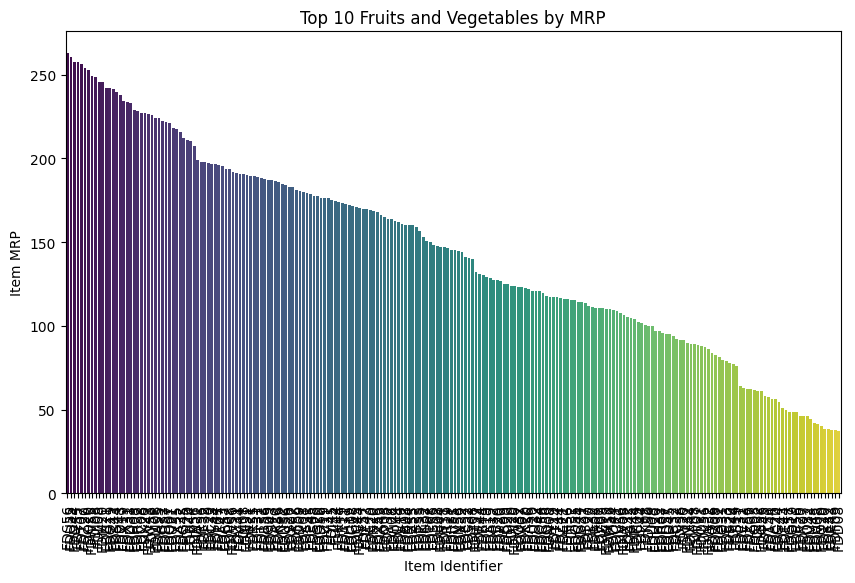

In [32]:
veggies = df_train[df_train['Item_Type_Fruits and Vegetables'] == True]
mrp_by_veggies = veggies.groupby('Item_Identifier')[['Item_MRP']].mean()
mrp_by_veggies_sorted = mrp_by_veggies.sort_values(by='Item_MRP', ascending=False)

# Plot the top 10 soft drinks by MRP
plt.figure(figsize=(10, 6))
sns.barplot(x=mrp_by_veggies_sorted.index, y=mrp_by_veggies_sorted['Item_MRP'], palette='viridis')
plt.title('Top 10 Fruits and Vegetables by MRP')
plt.xlabel('Item Identifier')
plt.ylabel('Item MRP')
plt.xticks(rotation=90)
plt.show()


More expensive Fruits and Vegetables usually do more sells this tells that they are almost evenly purchased by consumers.

As seen below the trend is the same in supermarkets and grocery stores

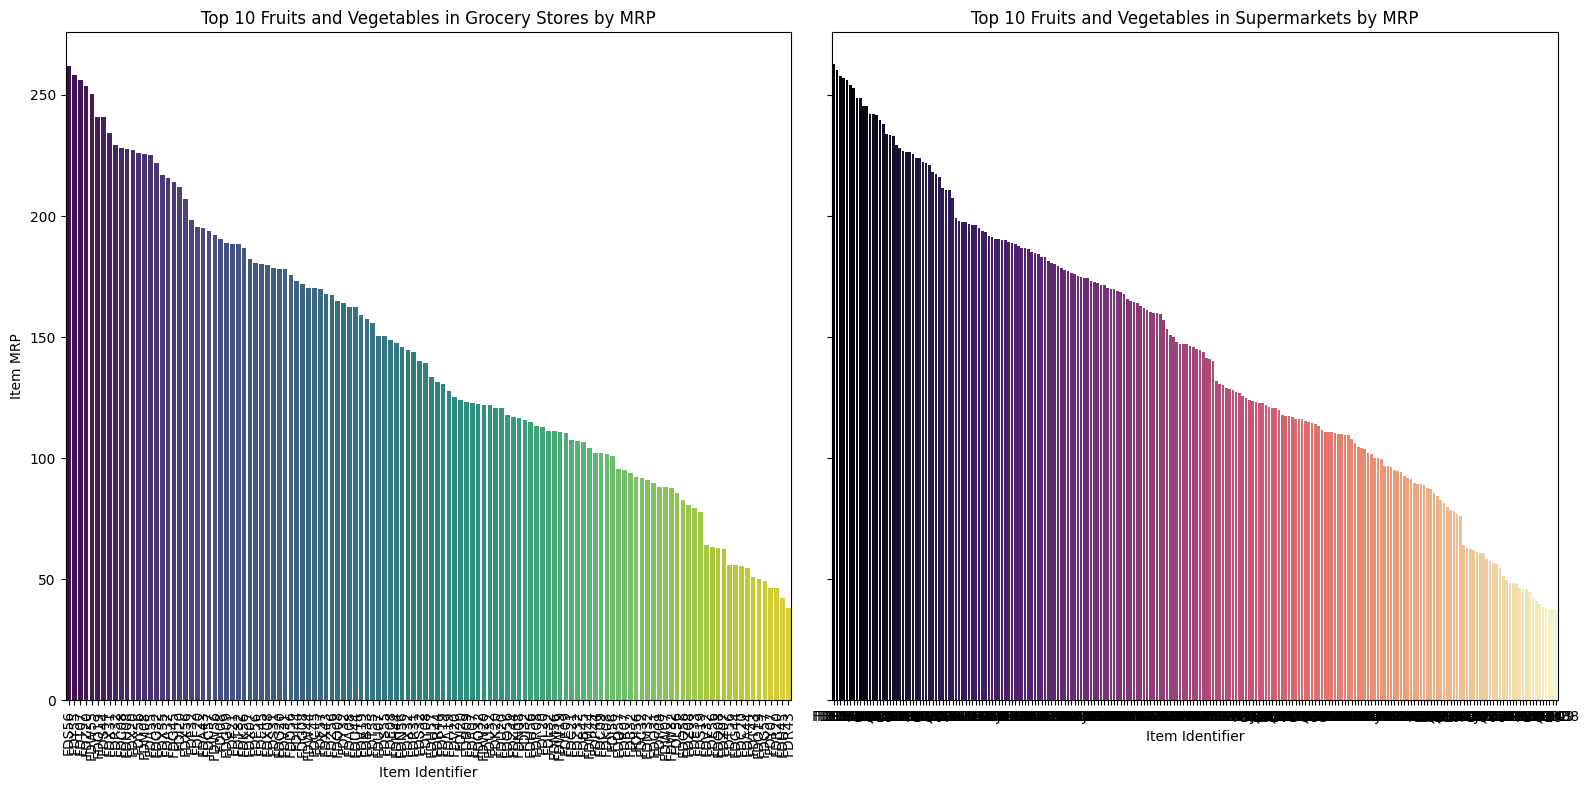

In [33]:
grocery_veggies = df_grocery[df_grocery['Item_Type_Fruits and Vegetables'] == True]
grocery_mrp_veggies = (
    grocery_veggies.groupby('Item_Identifier')[['Item_MRP']]
    .mean()
    .sort_values(by='Item_MRP', ascending=False)
)

supermarket_veggies = df_supermarket[df_supermarket['Item_Type_Fruits and Vegetables'] == True]
supermarket_mrp_veggies = (
    supermarket_veggies.groupby('Item_Identifier')[['Item_MRP']]
    .mean()
    .sort_values(by='Item_MRP', ascending=False)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.barplot(
    x=grocery_mrp_veggies.index,
    y=grocery_mrp_veggies['Item_MRP'],
    palette='viridis',
    ax=axes[0],
)
axes[0].set_title('Top 10 Fruits and Vegetables in Grocery Stores by MRP')
axes[0].set_xlabel('Item Identifier')
axes[0].set_ylabel('Item MRP')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(
    x=supermarket_mrp_veggies.index,
    y=supermarket_mrp_veggies['Item_MRP'],
    palette='magma',
    ax=axes[1],
)
axes[1].set_title('Top 10 Fruits and Vegetables in Supermarkets by MRP')
axes[1].set_xlabel('Item Identifier')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


The most influential variables are thus Outlet_Selection and MRP of item for Sales

We would now like to see how number of items sold are affected by the MRP of the item.

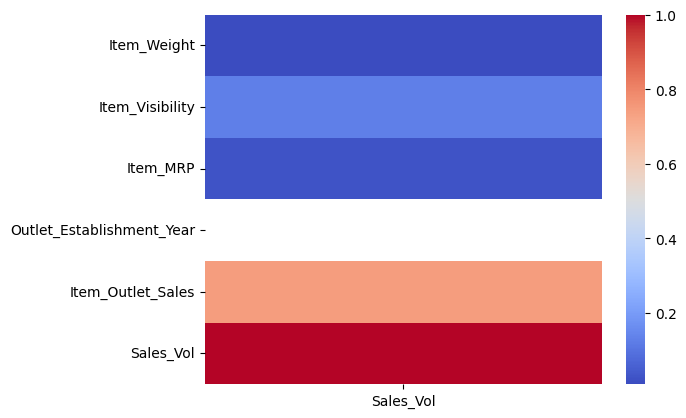

In [34]:
dummy = pd.read_csv('train_v9rqX0R.csv')

# We will pick a single grocery store
groc = dummy[dummy["Outlet_Identifier"] == 'OUT010']

gfro = groc[groc["Item_Type"] == "Fruits and Vegetables"]
gfro["Sales_Vol"] = gfro["Item_Outlet_Sales"] / gfro["Item_MRP"]

numeric_gfro = gfro.select_dtypes(include=['number'])

correlation_matrix = numeric_gfro.corr()

sns.heatmap(correlation_matrix[['Sales_Vol']], cmap='coolwarm')
plt.show()

This is very interesting to see that the number of items sold are unaffected by MRP of the item. Let's fetch some more information

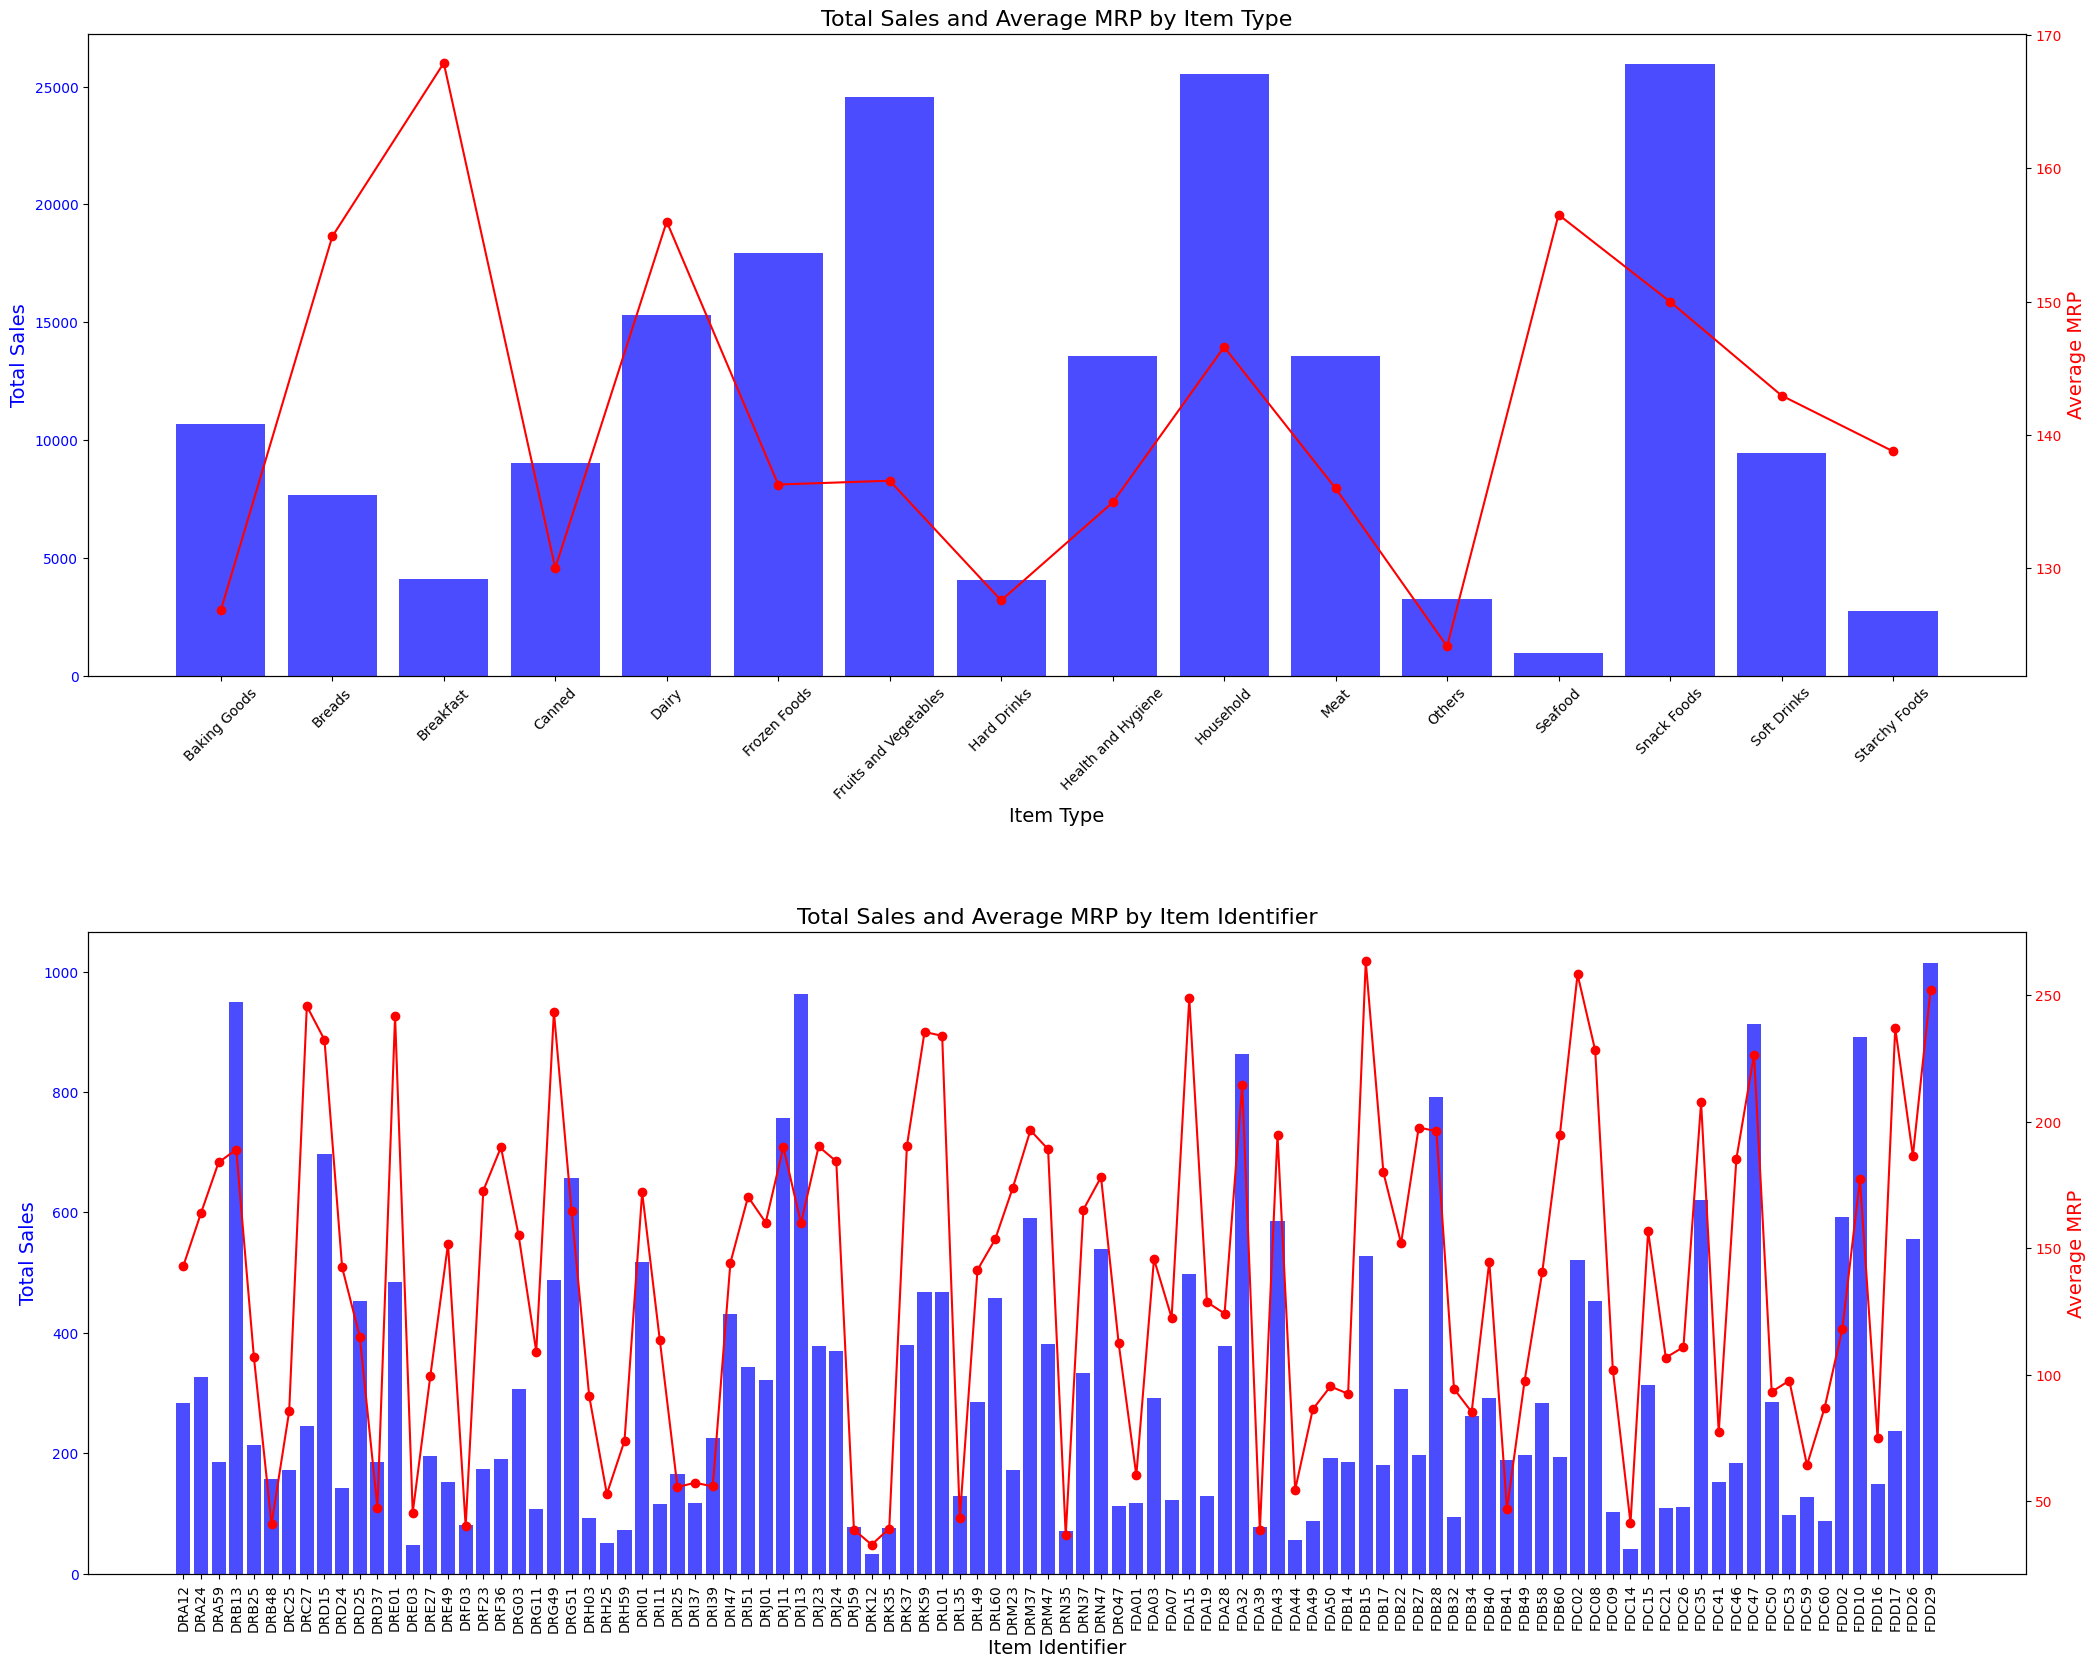

In [35]:
dummy = pd.read_csv('train_v9rqX0R.csv')

# We will work on a single grocery store
groc = dummy[dummy["Outlet_Identifier"] == 'OUT010']

# First Plot: Sales and MRP by Item_Type
sales_by_item_type = groc.groupby('Item_Type')["Item_Outlet_Sales"].sum()
mrp_by_item_type = groc.groupby('Item_Type')["Item_MRP"].mean()

# Second Plot: Sales and MRP by Item_Identifier
sales_by_item_id = groc.groupby('Item_Identifier')["Item_Outlet_Sales"].sum()
mrp_by_item_id = groc.groupby('Item_Identifier')["Item_MRP"].mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 20), gridspec_kw={'hspace': 0.4})

# First subplot: By Item_Type
ax1 = axes[0]
ax1.bar(sales_by_item_type.index, sales_by_item_type.values, color='blue', alpha=0.7, label='Total Sales')
ax1.set_ylabel('Total Sales', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Item Type', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1_twin = ax1.twinx()
ax1_twin.plot(mrp_by_item_type.index, mrp_by_item_type.values, color='red', marker='o', label='Average MRP')
ax1_twin.set_ylabel('Average MRP', color='red', fontsize=14)
ax1_twin.tick_params(axis='y', labelcolor='red')
ax1.set_title('Total Sales and Average MRP by Item Type', fontsize=16)

# Second subplot: By Item_Identifier
ax2 = axes[1]
ax2.bar(sales_by_item_id.head(100).index, sales_by_item_id.head(100).values, color='blue', alpha=0.7, label='Total Sales')
ax2.set_ylabel('Total Sales', color='blue', fontsize=14)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_xlabel('Item Identifier', fontsize=14)
ax2.tick_params(axis='x', rotation=90)
ax2_twin = ax2.twinx()
ax2_twin.plot(mrp_by_item_id.head(100).index, mrp_by_item_id.head(100).values, color='red', marker='o', label='Average MRP')
ax2_twin.set_ylabel('Average MRP', color='red', fontsize=14)
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2.set_title('Total Sales and Average MRP by Item Identifier', fontsize=16)

plt.tight_layout()
plt.show()


### Insight
In this case, the Sales_Volume is not dependent upon the MRP of the item, as witnessed in their correlation. We can see from the above charts that MRP and Sales_Volume do not have a simple linear relation. This is mainly due to retail stores *already keeping* the items that make **good sales**, which is why it doesn't matter what is being sold, it matters more where is it being sold. In our case, no stores are keeping items that are not demanded by consumer, each type has its consumers avaiable

Our initial assumption was wrong

In our case, the response variable does not depend much upon type of item type, fat content but it has a simple linear relationship with the MRP of the item and the type of Outlet and somewhat of a connect to the location.

We will now train our final model in Linear Regression and make submission

In [36]:

df_test = pd.read_csv('test_AbJTz2l.csv')
df_test.drop(columns=['Item_Weight', 'Outlet_Size'], inplace=True)
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace(
    {'Low Fat': 'lf', 'LF': 'lf', 'low fat': 'lf', 'Regular': 'reg', 'reg': 'reg'}
)
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].map({'lf': 0, 'reg': 1})
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace({0: 1, 1: 2})
valid_item_types = [
    'Fruits and Vegetables', 'Snack Foods', 'Frozen Foods', 'Dairy', 
    'Canned', 'Baking Goods', 'Meat', 'Starchy Foods', 'Breakfast', 'Seafood'
]
df_test.loc[~df_test['Item_Type'].isin(valid_item_types), 'Item_Fat_Content'] = 0
df_test['Decade'] = df_test['Outlet_Establishment_Year'].apply(categorize_decade)
df_test = pd.get_dummies(df_test, columns=['Decade'], drop_first=False)
df_test = df_test.drop('Outlet_Establishment_Year', axis=1)
df_test = pd.get_dummies(df_test, columns=['Item_Type'], drop_first=False)
df_test['Outlet_Location_Type'] = df_test['Outlet_Location_Type'].map({'Tier 1': 1, 'Tier 2': 2, 'Tier 3': 3})
df_test = pd.get_dummies(df_test, columns=['Outlet_Type'], prefix='Outlet_Type', drop_first=False)
df_test['Item_Visibility'], _ = stats.boxcox(df_test['Item_Visibility'] + 1)


In [37]:
IDs = ['Item_Identifier', 'Outlet_Identifier']
Response = 'Item_Outlet_Sales'

vif_data = pd.DataFrame()
vifD = df_train.drop(columns=[*IDs, Response])
vifD["Const"] = 1
vif_data["Feature"] = vifD.columns
vif_data["VIF"] = [variance_inflation_factor(vifD.values.astype(float), i) for i in range(vifD.shape[1])]
vif_data

,Feature,VIF
0,Item_Fat_Content,3.599310
1,Item_Visibility,1.063989
2,Item_MRP,1.012851
3,Outlet_Location_Type,1.869564
4,Decade_80s,inf
5,Decade_90s,inf
6,Decade_late 00s,inf
7,Decade_mid 00s,inf
8,Item_Type_Baking Goods,inf
9,Item_Type_Breads,inf


The numerical features, do not have unwanted levels of multicollinearity hence we will keep the numerical features

In [38]:
X = df_train.drop(columns=[*IDs, Response])
y = df_train[Response]

X["Intercept"] = 1

kf = KFold(n_splits=5, shuffle=True, random_state=8317)

xgb_model = XGBRegressor(random_state=8317)
lr_model = LinearRegression()

def rmse(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, y_pred))

xgb_rmse_list = []
lr_rmse_list = []
xgb_train_loss = []
lr_train_loss = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    xgb_model.fit(X_train, y_train)
    xgb_train_loss.append(np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
    
    lr_model.fit(X_train, y_train)
    lr_train_loss.append(np.sqrt(mean_squared_error(y_train, lr_model.predict(X_train))))
    
    xgb_rmse = rmse(xgb_model, X_train, y_train, X_val, y_val)
    xgb_rmse_list.append(xgb_rmse)
    
    lr_rmse = rmse(lr_model, X_train, y_train, X_val, y_val)
    lr_rmse_list.append(lr_rmse)

xgb_mean_rmse = np.mean(xgb_rmse_list)
lr_mean_rmse = np.mean(lr_rmse_list)


XGBoost RMSE: 1183.999710594011

LinearRegression RMSE: 1132.3187996242236

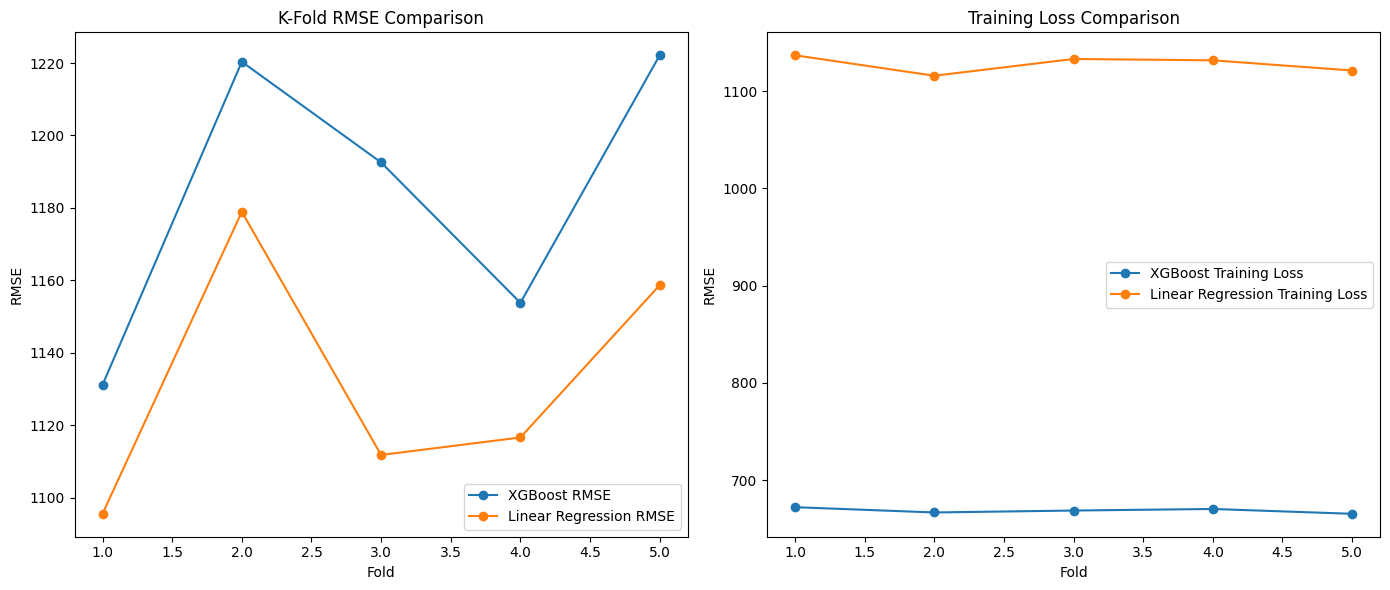

In [39]:

print(f"XGBoost RMSE: {xgb_mean_rmse}")
print(f"LinearRegression RMSE: {lr_mean_rmse}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), xgb_rmse_list, label='XGBoost RMSE', marker='o')
plt.plot(range(1, 6), lr_rmse_list, label='Linear Regression RMSE', marker='o')
plt.title('K-Fold RMSE Comparison')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), xgb_train_loss, label='XGBoost Training Loss', marker='o')
plt.plot(range(1, 6), lr_train_loss, label='Linear Regression Training Loss', marker='o')
plt.title('Training Loss Comparison')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:


model = LinearRegression()

X = df_train.drop(columns=[Response, *IDs])
y = df_train[Response]

model.fit(X, y)
preds = np.clip(model.predict(df_test.drop(columns=IDs)), 0, None)

submission = pd.DataFrame({
    'Item_Identifier': df_test['Item_Identifier'], 
    'Outlet_Identifier': df_test['Outlet_Identifier'], 
    'Item_Outlet_Sales': preds
})
submission.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'")


Predictions saved to 'submission.csv'

This LR final model gives RMSE of 1186 on the hackathon compared to the tree based regressor which gives 1191

Final rank 3699 / 51823 on public leaderboard